In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

In [22]:
Nghost = 2 # Number of ghost zones

# Define a class to hold the parameters of the hydrodynamics simulation
# and run the sim and handled the results
class Burgers(object):
    def __init__(self, Ncells, IC, outCad=0): 
        self._outCad = outCad
        self._t = 0.0
        self._N = Ncells+2*Nghost
        self._dx = 1.0/Ncells 
        self._x = np.linspace((0.5-Nghost)*self._dx,1+(Nghost-0.5)*self._dx, Ncells+2*Nghost)
        self._u = self._getIC(IC, self._x) 
        self._dt = 0.25*self._dx
    def _getIC(self,IC, x):
        if (IC=="sine"):
            return 0.35+0.25*np.sin(4.0*np.pi*x)
        elif (IC=="step"):
            f = np.ones_like(x)
            f[abs(x-0.5)<0.25] = 0.5
            return f
        else:
            raise ValueError("IC undefined")       
    # def _minmod(self, u)
        
    def _physFlux(self, u):
        return 0.5*u**2
    def _flux(self, ul, ur): #ul/ur is left/right of interface
        # using Roe's method to compute flux
        uavg = 0.5*(ul+ur)
        delta = ur-ul
        #No shock capturing
        return (
                0.5*(self._physFlux(ul)+self._physFlux(ur))#No shock capturing
#                 -0.5*abs(uavg)*delta
               )
    def _uPlusMinus(self, u):
        #Linear interpolation to interface
        up = 1.0*u
        up[:-1] = 0.5*(u[1:]+u[:-1])
        um = 1.0*u
        um[1:] = 0.5*(u[1:]+u[:-1])
        return (up,um)
        # Min-mod
#         slope = np.zeros_like(u) #intialize array for the slope
#         deltau = u[1:]-u[:-1]
#         slope[1:-1] = deltau[1:] #initialze the slope as deltau
#         slope[1:-1][abs(deltau[1:])>abs(deltau[:-1])] = deltau[:-1][abs(deltau[1:])>abs(deltau[:-1])] #if deltau[1:] > dletau[:-1] then the slope is deltau[:-1]
#         slope[1:-1][abs(deltau[1:])*abs(deltau[:-1])<=0] = 0
#         return (u+0.5*slope,u-0.5*slope)
    def _udot(self, u):
        #Calculate left and right hand states at interfaces
        up,um = self._uPlusMinus(u)
        F = np.zeros(len(u)+1)
        #Calculate flux at interfaces
        F[1:-1] = self._flux(up[:-1],um[1:])
        return (1.0/self._dx)*(F[:-1]-F[1:])
    def _applyBC(self, u):
        #Copy over ghost cells assuming periodic BCs
        ubc = 1.0*u
        ubc[0:Nghost] = u[-(2*Nghost):-Nghost]
        ubc[-Nghost:] = u[Nghost:2*Nghost]
        return ubc
    def _step(self):
        #Use Runge-Kutta 2
        uhalf = self._u + 0.5*self._dt*self._udot(self._u)
        uhalf = self._applyBC(uhalf)
        self._u += self._dt*self._udot(uhalf)
        self._u = self._applyBC(self._u)
        self._t += self._dt
    def evolve(self, tf, save=True, show=False):
        while(self._t<tf):
            if (self._outCad>0): self._output(save=save, show=show)
            self._step()
            if (round(self._t,8)==0.20): np.savetxt("50ncells0.2tnosl.txt", self._u[Nghost:-Nghost])
        if (self._outCad>0): self._output(save=save, show=show)
    def _output(self, save=True, show=False):
        nstep = np.rint(self._t/self._dt)
        if (nstep%self._outCad!=0): return
        plt.clf()
        plt.ylabel(r"u")
        plt.xlabel(r"x")
        plt.title("t=%1.2f"%self._t)
        plt.plot(self._x[Nghost:-Nghost], self._u[Nghost:-Nghost], "k-")
        #plt.ylim([0.1,0.6])
        if show:
            plt.show()
        if save:
            plt.savefig("fig_%d.png" % (nstep/self._outCad)) 
    def plotReconstruction(self):
        up,um = self._uPlusMinus(self._u)
        stencil = 0.5*self._dx*np.array([-1,0,1])
        plt.plot(self._x[Nghost:-Nghost],self._u[Nghost:-Nghost],"ro")
        for n in range(Nghost,self._N-Nghost):
            plt.plot(stencil+self._x[n],[um[n],self._u[n],up[n]],"k")
        plt.xlabel(r"$x$")
        plt.ylabel(r"$u$")
        plt.show()
    def getSoln(self):
        return self._u[Nghost:-Nghost]
    def getDomain(self):
        return self._x[Nghost:-Nghost]
    def getMass(self):
        return self._dx*np.sum(self._u[Nghost:-Nghost])


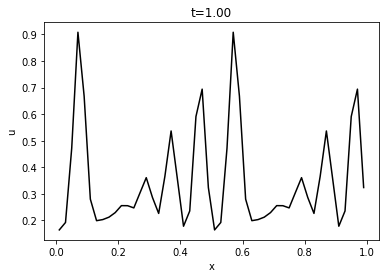

In [23]:
# delete output files from a possible previous run
os.system('rm fig*.png animation.mp4')

# Parameter values:

# Number of cells in the simulation
Ncells = 50

# Initial conditions -- 'sine' or 'step'
IC = 'sine'

# Output cadence -- how often to produce a plot
outCad = 8

# Final time -- how long to run the simulation for
tf = 1.0

burgers = Burgers(Ncells, IC, outCad=outCad)
# If you pass 'show=True', it will display a series of plots;
# if you pass 'save=True' (the default), it will also save a series of .png plots...
burgers.evolve(tf, save=True)

# ... which you can convert into a movie "animation.mp4".
# If you're running on Symmetry, you will have to download the animation.mp4 file to your computer to view it.
os.system('ffmpeg -r 12 -i fig_%d.png -qscale:v 0 -pix_fmt yuv420p -c:v libx264 -crf 20 -r 24 animation.mp4');

In [ ]:
wr

In [ ]:
dt